**Table of contents**<a id='toc0_'></a>    
- [ロボットアーム](#toc1_)    
- [pybulletの起動](#toc2_)    
- [手先カメラ](#toc3_)    
    - [初期設定](#toc3_1_1_)    
    - [シミュレーションの実行](#toc3_1_2_)    
    - [取得した画像のアニメーション化](#toc3_1_3_)    
- [力センサ](#toc4_)    
  - [初期設定](#toc4_1_)    
  - [シミュレーションの実行](#toc4_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[ロボットアーム](#toc0_)

本notebookでは2軸のロボットアームに搭載されたセンサーの使用方法について解説します。

具体的には、以下のセンサが搭載された移動ロボットを使用します。
- 手先カメラ
- 力センサ

![](../images/RobotArm/2d_robot_arm_sensor.png)

（pybulletで使用可能な関数がまとめられたマニュアルについては[こちら](https://github.com/bulletphysics/bullet3/blob/master/docs/pybullet_quickstartguide.pdf)を参照してください。）

# <a id='toc2_'></a>[pybulletの起動](#toc0_)

pybulletを起動します。

以降は、各センサで独立したコードになっているため、お好きな順番でお試しください。

In [1]:
import time
import math
import pybullet
import pybullet_data
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt
physics_client = pybullet.connect(pybullet.GUI) 

pybullet build time: Nov 28 2023 23:45:17


startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Mesa
GL_RENDERER=llvmpipe (LLVM 15.0.7, 256 bits)
GL_VERSION=4.5 (Core Profile) Mesa 23.2.1-1ubuntu3.1~22.04.2
GL_SHADING_LANGUAGE_VERSION=4.50
pthread_getconcurrency()=0
Version = 4.5 (Core Profile) Mesa 23.2.1-1ubuntu3.1~22.04.2
Vendor = Mesa
Renderer = llvmpipe (LLVM 15.0.7, 256 bits)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started


ven = Mesa
ven = Mesa


# <a id='toc3_'></a>[手先カメラ](#toc0_)


### <a id='toc3_1_1_'></a>[初期設定](#toc0_)

床の生成、ボックスオブジェクトの生成、ロボットの生成、カメラ位置の設定などの初期設定を行います。

In [2]:
pybullet.resetSimulation() # シミュレーション空間をリセット
pybullet.setAdditionalSearchPath(pybullet_data.getDataPath()) # pybulletに必要なデータへのパスを追加
pybullet.setGravity(0.0, -9.8, 0.0) # 2次元平面なので、y軸方向に重力を設定
time_step = 1./240.
pybullet.setTimeStep(time_step)

#床の読み込み
plane_start_pos = [0, 0, 0]
plane_start_orientation = pybullet.getQuaternionFromEuler([-1.57, 0, 0]) # 2次元平面なので、正面がx-y平面になるように回転
plane_id = pybullet.loadURDF("plane.urdf", plane_start_pos, plane_start_orientation) 

# ボックスの読み込み
## ボックスの重さ、サイズ、位置·姿勢を決める
mass = 5 # kg
box_size = [0.6, 0.6, 0.5]
position = [-2, 0.5, 0.25]
orientation = [1, 0, 0, 0] # 四元数
box_collision_id = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=box_size, physicsClientId=physics_client)
box_visual_id = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=box_size, physicsClientId=physics_client, rgbaColor=[1,0,0,1]) # 赤・半透明
box_body_id = pybullet.createMultiBody(mass, box_collision_id, box_visual_id, position, orientation, physicsClientId=physics_client)


# ロボットの読み込み
arm_start_pos = [0, 0, 0.1]  # 初期位置(x,y,z)を設定
arm_start_orientation = pybullet.getQuaternionFromEuler([1.57, 0, 3.14])  # 初期姿勢(roll, pitch, yaw)を設定
arm_id = pybullet.loadURDF("../urdf/simple2d_arm.urdf",arm_start_pos, arm_start_orientation, useFixedBase=True)

# GUIモードの際のカメラの位置などを設定
camera_distance = 1.5
camera_yaw = 180.0 # deg
camera_pitch = -91 # deg
camera_target_position = [0.0, 1.0, 1.0]
pybullet.resetDebugVisualizerCamera(camera_distance, camera_yaw, camera_pitch, camera_target_position)

b3Printf: b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:

b3Printf: No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frame
b3Printf: b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:

b3Printf: target_position_vertual_link


### <a id='toc3_1_2_'></a>[シミュレーションの実行](#toc0_)

pybulletでは `getCameraImage`という関数を使用することでカメラ画像を取得することが出来ます。

```python
width, height, rgbImg, depthImg, segImg = pybullet.getCameraImage(300,300, viewMatrix, projectionMatrix)
```

ここで、
- `viewMatrix`は「カメラをどの位置から撮影するか」などの情報が含まれた変数
- `projectionMatrix`は「カメラの設定（どの程度の距離の物体まで撮影するかなど）」に関する情報が含まれた変数

になります。

ここで、重要となるのが`viewMatrix`関数になります。

`viewMatrix`は`computeViewMatrix`関数を使用して作成します。

```python
viewMatrix = pybullet.computeViewMatrix(cameraEyePosition,cameraTargetPosition,cameraUpVector)
```

ここで、
- `cameraEyePosition`はカメラの始点
- `cameraTargetPosition`はカメラの注視点
- `cameraUpVector`は、カメラの上方向のベクトル
  - 今回、ロボットアームの手先にカメラが取り付けられているため、アームの姿勢によって「カメラの上方向」も変わることになります。そのため、アームの姿勢に応じて、`cameraUpVector`を計算しています。

となり、図にすると以下のようになります。

![](../images/Common/camera_explain.jpeg)

※ pybulletにおけるカメラの扱いについては[こちら](https://qiita.com/akinami/items/3aec8671cec2eeb33129)でも解説しています。

<br>

シミュレーションを実行すると、ロボットアームの手先に取り付けられたカメラから画像を取得することが出来ます。

In [3]:
# 2次元平面における回転行列（2次元平面における回転は、z軸周りの回転）
def Rz(theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0],
                     [np.sin(theta), np.cos(theta), 0],
                     [0, 0, 1]])

In [4]:
# ロボットの初期姿勢を設定
joint1_initial_deg = 0 # deg
joint2_initial_deg = 0 # deg
pybullet.resetJointState(arm_id, 0, math.radians(joint1_initial_deg))
pybullet.resetJointState(arm_id, 1, math.radians(joint2_initial_deg))

# シミュレーション設定
time_length = 400 # 何時刻分シミュレーションするか
save_img_freq = 1 # 画像を保存する頻度（値が小さいほどより滑らかな動画になるが、処理時間が増加する）

# 目標角度（ここの値を変更） ======================================
joint1_deg = math.radians(180)
joint2_deg = math.radians(0)
# ===============================================================

# カメラ設定
projection_matrix = pybullet.computeProjectionMatrixFOV(fov=45.0,aspect=1.0,nearVal=0.1,farVal=10)

# 取得したカメラ画像を格納するリスト
frames = []

# 各ジョイントのインデックス
LINK1_JOINT_IDX = 0
LINK2_JOINT_IDX = 1

# 各リンクのインデックス
CAMERA_IDX = 2
CAMERA_TARGET_IDX = 3
FORCE_SENSOR_LINK_IDX = 4 # 手先の軌跡描画用

# デフォルトのcameraUpVector
camera_up_vector = [0, -1, 0]

pybullet.setRealTimeSimulation(0)
for t in range (time_length):
    # 各関節を速度制御
    pybullet.setJointMotorControl2(arm_id, LINK1_JOINT_IDX, pybullet.VELOCITY_CONTROL, targetVelocity=5)
        
    # シミュレーションを一時刻（240Hz）分進める
    pybullet.stepSimulation()

    if t % save_img_freq == 0:
        # アームの前面位置になるようにカメラを設定
        camera_link_pose = pybullet.getLinkState(arm_id, CAMERA_IDX)[0] # 手先のカメラリンクの位置
        camera_target_link_pose = pybullet.getLinkState(arm_id, CAMERA_TARGET_IDX)[0] # カメラリンクの少しだけ前に設定した仮想的なリンクの位置

        # cameraUpVectorをアームの関節角度に合わせて計算
        q1 = pybullet.getJointState(arm_id, LINK1_JOINT_IDX)[0] # リンク1の関節角度
        q2 = pybullet.getJointState(arm_id, LINK2_JOINT_IDX)[0] # リンク2の関節角度
        R12 = Rz(q1) # リンク1座標系 → リンク2座標系への回転行列
        R2C = Rz(q2) # リンク2座標系 → カメラ座標系への回転行列
        rotate_camera_up_vector = R12@R2C@camera_up_vector

        # 手先カメラから画像を取得
        view_matrix = pybullet.computeViewMatrix(cameraEyePosition=[camera_link_pose[0], camera_link_pose[1], camera_link_pose[2]],cameraTargetPosition=[camera_target_link_pose[0], camera_target_link_pose[1], camera_target_link_pose[2]],cameraUpVector=rotate_camera_up_vector)
        
        # renderer=pybullet.ER_BULLET_HARDWARE_OPENGLを指定することで、画質は下がる分高速に画像を取得できる
        width, height, rgb_img, depth_img, seg_img = pybullet.getCameraImage(300,300, view_matrix, projection_matrix, renderer=pybullet.ER_BULLET_HARDWARE_OPENGL)
        frames.append(rgb_img)
    time.sleep(time_step)

KeyboardInterrupt: 

### <a id='toc3_1_3_'></a>[取得した画像のアニメーション化](#toc0_)

取得した画像をアニメーション化して表示します。  

(GUI画面で表示したときと比較して、アニメーションの速度が速いと思いますが、これは`getCameraImage`関数の処理が遅いためであり、本来の速度は下記コードで生成されるアニメーションの速度になります。)

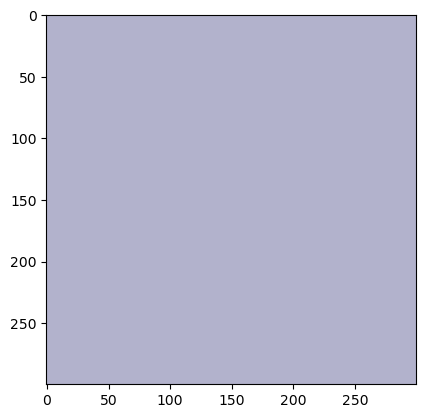

In [27]:
# jupyter book内にアニメーションを表示
def update(time, frames):
    plt.cla()
    frames_np = np.asarray(frames[time])
    plt.imshow(frames_np)

fig = plt.figure()
time_step_milli_sec = time_step * 1000
ani = FuncAnimation(fig, update, interval=time_step_milli_sec*save_img_freq, frames=len(frames), fargs=(frames,))
HTML(ani.to_jshtml()) # HTMLに
#ani.save('robot_camera.mp4', writer="ffmpeg") # mp4で保存．これを実行すると処理時間が増加します
# ani.save('robot_camera.gif', writer="imagemagick") # gifで保存．これを実行すると処理時間が増加します

# <a id='toc4_'></a>[力センサ](#toc0_)

## <a id='toc4_1_'></a>[初期設定](#toc0_)

床の生成、ボックスオブジェクトの生成、ロボットの生成、カメラ位置の設定などの初期設定を行います。

In [6]:
pybullet.resetSimulation() # シミュレーション空間をリセット
pybullet.setAdditionalSearchPath(pybullet_data.getDataPath()) # pybulletに必要なデータへのパスを追加
pybullet.setGravity(0.0, 0.0, -9.8) # 地球上における重力に設定
time_step = 1./240.
pybullet.setTimeStep(time_step)

#床の読み込み
plane_id = pybullet.loadURDF("plane.urdf")

# ボックスの読み込み
## ボックスの重さ、サイズ、位置·姿勢を決める
mass = 5 # kg
box_size = [0.3, 0.5, 0.3]
position = [-0.8, 0, 0.3]
orientation = [1, 0, 0, 0] # 四元数
box_collision_id = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=box_size, physicsClientId=physics_client)
box_visual_id = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=box_size, physicsClientId=physics_client, rgbaColor=[1,0,0,1]) # 赤・半透明
box_body_id = pybullet.createMultiBody(mass, box_collision_id, box_visual_id, position, orientation, physicsClientId=physics_client)


# ロボットの読み込み
arm_start_pos = [0, 0, 0.1]  # 初期位置(x,y,z)を設定
arm_start_orientation = pybullet.getQuaternionFromEuler([0,0,0])  # 初期姿勢(roll, pitch, yaw)を設定
arm_id = pybullet.loadURDF("../urdf/simple2d_arm.urdf",arm_start_pos, arm_start_orientation, useFixedBase=True)

# GUIモードの際のカメラの位置などを設定
camera_distance = 2.0
camera_yaw = 180.0 # deg
camera_pitch = -10 # deg
camera_target_position = [0.0, 0.0, 1.0]
pybullet.resetDebugVisualizerCamera(camera_distance, camera_yaw, camera_pitch, camera_target_position)

b3Printf: b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:

b3Printf: No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frame
b3Printf: b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:

b3Printf: target_position_vertual_link


## <a id='toc4_2_'></a>[シミュレーションの実行](#toc0_)

pybulletでは、`getJointState`関数を使用することで各ジョイントの情報を取得できます。  
この関数では、位置情報の他に力情報も取得できるため、バンパーセンサでは力情報を使用して障害物との衝突を検知します。

シミュレーションを開始すると、ロボットアームが動き出し、ボックスのオブジェクトに手先が接触すると停止します。

- `enableJointForceTorqueSensor`の`enableSensor`を1に設定すると、手先に障害物が接触した際にロボットが停止します。
- `enableJointForceTorqueSensor`の`enableSensor`を0に設定すると、手先に障害物が接触しても反応せずに、動き続けます。


In [7]:
# ロボットの初期姿勢を設定
joint1_initial_deg = 0 # deg
joint2_initial_deg = 0 # deg
pybullet.resetJointState(arm_id, 0, math.radians(joint1_initial_deg))
pybullet.resetJointState(arm_id, 1, math.radians(joint2_initial_deg))

# 手先の力センサを有効化
FORCE_SENSOR_JOINT_IDX = 4
pybullet.enableJointForceTorqueSensor(arm_id, FORCE_SENSOR_JOINT_IDX, enableSensor=1)

for i in range(500):
    # 手先の力センサに加わる力を取得
    joint_state = pybullet.getJointState(arm_id, FORCE_SENSOR_JOINT_IDX)
    force_x = joint_state[2][0]
    force_y = joint_state[2][1]
    force_z = joint_state[2][2]

    # 画面上に手先の力センサに加わっている力を表示
    text_position = [1.0, -0.5, 1.5]
    life_time = 0.1 # 表示期間（秒）
    pybullet.addUserDebugText(f"force x:{force_x:.2f} y:{force_y:.2f} z:{force_z:.2f}", text_position, textSize=3, lifeTime=life_time, textColorRGB=[0,0,0])

    # 手先の力センサに対して、5以上の力が加わった場合、停止
    if force_z > 5:
        text_position = [1.0, -0.5, 2.0]
        life_time = 0.1 # 表示期間（秒）
        pybullet.addUserDebugText(f"force sensor ON", text_position, textSize=5, lifeTime=0.1, textColorRGB=[1,0,0])
        pybullet.setJointMotorControl2(arm_id, 0, pybullet.VELOCITY_CONTROL, targetVelocity=0)
        pybullet.setJointMotorControl2(arm_id, 1, pybullet.VELOCITY_CONTROL, targetVelocity=0)
    else:
        # 回転
        pybullet.setJointMotorControl2(arm_id, 0, pybullet.VELOCITY_CONTROL, targetVelocity=-1)
        pybullet.setJointMotorControl2(arm_id, 1, pybullet.VELOCITY_CONTROL, targetVelocity=-1)

    # 次のステップへ
    pybullet.stepSimulation()
    time.sleep(time_step)